In [10]:
# ===========================================
# Step 0: Imports and Data Loading
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

# Set global style
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10


# Load cleaned data
url_base = "https://raw.githubusercontent.com/zingeroff/Restaurant_Sales_Analysis/main/data"
orders = pd.read_csv(f"{url_base}/orders_cleaned.csv")
guests = pd.read_csv(f"{url_base}/guests.csv")


# Rename columns if they contain special chars
orders.rename(columns={
    'total_price ($)': 'total_price',
    'cost ($)': 'cost',
    'discount (%)': 'discount'
}, inplace=True, errors='ignore')

print("Data loaded successfully!")
print("Data shape:", orders.shape)
print(orders.head())


Data loaded successfully!
Data shape: (150383, 9)
   order_id  client_id  order_date order_time  menu_item_id  quantity  \
0    900001       1126  2022-04-01   08:00:00           103         3   
1    900001       1126  2022-04-01   08:00:00           140         3   
2    900002       1594  2022-04-01   08:00:00           102         1   
3    900002       1594  2022-04-01   08:00:00           136         1   
4    900003       1864  2022-04-01   08:02:00           106         3   

   discount  total_price time_of_day  
0         0        38.97     Morning  
1         0         8.97     Morning  
2         0        13.50     Morning  
3         0         3.50     Morning  
4         0        32.97     Morning  


Optimal bin configuration:
- Recency: 5 bins
- Frequency: 5 bins
- Monetary: 5 bins


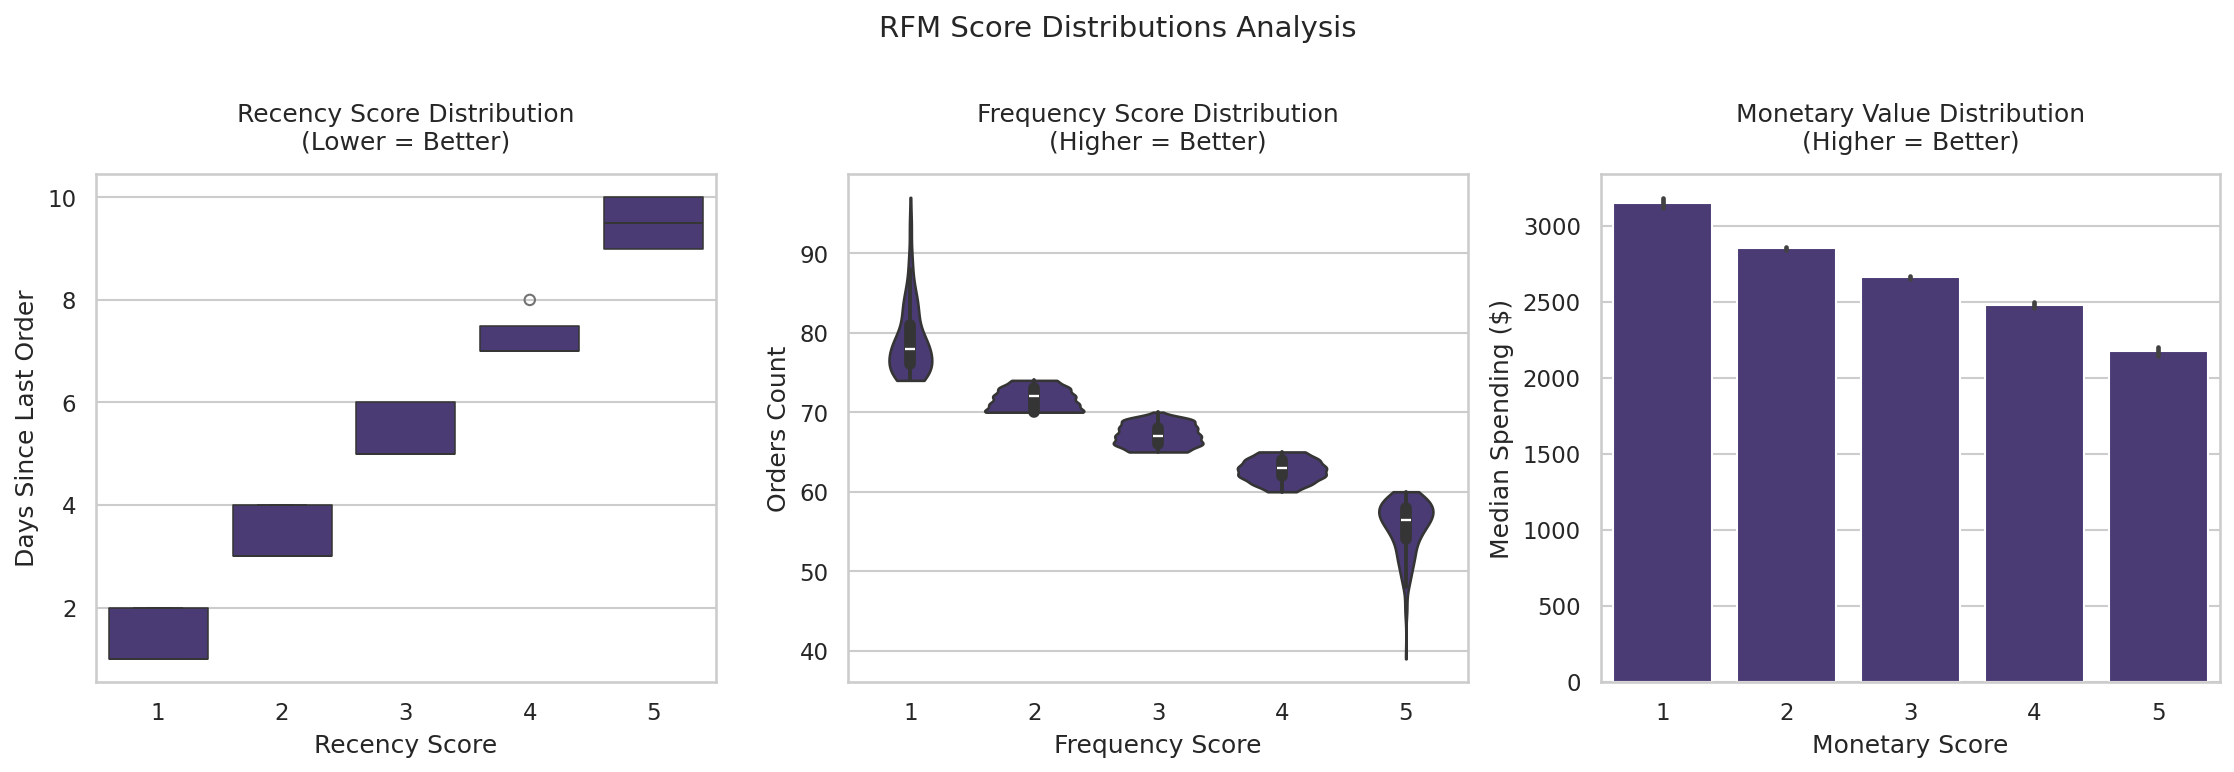

RFM analysis completed and saved successfully!


In [25]:

# ## 2. RFM Calculation with Advanced Binning
# %%
def calculate_rfm_scores(df: pd.DataFrame, max_bins: int = 5) -> pd.DataFrame:
    """
    Calculate RFM scores with dynamic bin adjustment

    Parameters:
        df: DataFrame with RFM metrics
        max_bins: Maximum number of bins to use

    Returns:
        DataFrame with R_Score, F_Score, M_Score
    """
    df = df.copy()

    def get_optimal_bins(series: pd.Series, max_bins: int) -> int:
        """Dynamically determine optimal number of bins"""
        unique_count = series.nunique()
        return min(max(unique_count, 1), max_bins)  # Ensure at least 1 bin

    def smart_qcut(series: pd.Series, max_bins: int, ascending: bool = True) -> pd.Series:
        """Robust quantile-based binning with fallback"""
        series = series.dropna()
        n_bins = get_optimal_bins(series, max_bins)

        if n_bins < 2:
            return pd.Series(1, index=series.index)

        try:
            if ascending:
                return pd.qcut(series, q=n_bins, labels=range(n_bins, 0, -1), duplicates='drop')
            return pd.qcut(series, q=n_bins, labels=range(1, n_bins+1), duplicates='drop')
        except Exception as e:

            return pd.cut(series, bins=n_bins, labels=range(1, n_bins+1), include_lowest=True)

    # Calculate scores
    print("Optimal bin configuration:")
    metrics = {
        'recency': ('R_Score', False),
        'frequency': ('F_Score', True),
        'monetary': ('M_Score', True)
    }

    for col, (score_col, ascending) in metrics.items():
        print(f"- {col.capitalize()}: {get_optimal_bins(df[col], max_bins)} bins")
        ranked_data = df[col].rank(method='first') if col == 'frequency' else df[col]
        df[score_col] = smart_qcut(ranked_data, max_bins, ascending).astype(int)

    return df


# 3. Enhanced Visualization

def plot_rfm_distribution(df: pd.DataFrame) -> None:
    """Plot professional RFM distribution diagnostics"""
    plt.figure(figsize=(15, 5), facecolor='white')

    # Recency Distribution
    plt.subplot(1, 3, 1)
    sns.boxenplot(x='R_Score', y='recency', data=df)
    plt.title('Recency Score Distribution\n(Lower = Better)', pad=12)
    plt.xlabel('Recency Score')
    plt.ylabel('Days Since Last Order')

    # Frequency Distribution
    plt.subplot(1, 3, 2)
    sns.violinplot(x='F_Score', y='frequency', data=df, cut=0)
    plt.title('Frequency Score Distribution\n(Higher = Better)', pad=12)
    plt.xlabel('Frequency Score')
    plt.ylabel('Orders Count')

    # Monetary Distribution
    plt.subplot(1, 3, 3)
    sns.barplot(x='M_Score', y='monetary', data=df, estimator=np.median)
    plt.title('Monetary Value Distribution\n(Higher = Better)', pad=12)
    plt.xlabel('Monetary Score')
    plt.ylabel('Median Spending ($)')

    # Annotations and styling
    plt.suptitle('RFM Score Distributions Analysis', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


#4. Implementation



# Merge datasets
merged_data = pd.merge(
    orders,
    guests[['guest_id', 'referral_source']],
    left_on='client_id',
    right_on='guest_id',
    how='left'
)

# Calculate RFM metrics
# Ensure 'order_date' is in datetime format
merged_data['order_date'] = pd.to_datetime(merged_data['order_date'], errors='coerce')

# Calculate analysis date
analysis_date = merged_data['order_date'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics
rfm = merged_data.groupby('client_id').agg(
    recency=('order_date', lambda x: (analysis_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('total_price', 'sum')
)

# Calculate scores
rfm_scored = calculate_rfm_scores(rfm, max_bins=5)

# Generate visualizations
plot_rfm_distribution(rfm_scored)


# 5. Segment Analysis

# Segment mapping
segment_map = {
    r'[4-5][4-5][4-5]': 'Champions',
    r'[3-5][3-5][3-5]': 'Loyal Customers',
    r'[3-5][1-3][1-3]': 'Potential Loyalists',
    r'[2-3][2-3][2-3]': 'Need Attention',
    r'[1-2][1-2][1-2]': 'At Risk'
}

rfm_scored['segment'] = rfm_scored['R_Score'].astype(str) + \
                       rfm_scored['F_Score'].astype(str) + \
                       rfm_scored['M_Score'].astype(str)

rfm_scored['segment'] = rfm_scored['segment'].replace(segment_map, regex=True)
rfm_scored['segment'] = rfm_scored['segment'].fillna('Other')

# Save results
rfm_scored.to_csv('rfm_results.csv', index=False)
print("RFM analysis completed and saved successfully!")

In [17]:
# ===========================================
# Step 2: Cohort Analysis
# ===========================================

import pandas as pd
import numpy as np

# Ensure 'order_date' is in datetime format
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Extract year and month for cohort grouping
orders['OrderMonth'] = orders['order_date'].dt.to_period('M')
orders['CohortMonth'] = orders.groupby('client_id')['order_date'].transform('min').dt.to_period('M')

# Function to extract year and month as integers from a Period column
def get_date_int(orders, column):
    """
    Helper function to extract year and month as integers from a Period column.
    """
    year = orders[column].dt.year
    month = orders[column].dt.month
    return year, month

# Apply the helper function to extract year and month for CohortMonth and OrderMonth
orders['CohortYear'], orders['CohortMonthNum'] = get_date_int(orders, 'CohortMonth')
orders['OrderYear'], orders['OrderMonthNum'] = get_date_int(orders, 'OrderMonth')

# Calculate Cohort Index
orders['CohortIndex'] = (orders['OrderYear'] - orders['CohortYear']) * 12 + (orders['OrderMonthNum'] - orders['CohortMonthNum']) + 1

# Create Cohort DataFrame
cohort_data = orders.groupby(['CohortMonth', 'CohortIndex'])['client_id'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='client_id')

# Calculate retention rates
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

print("Cohort retention rates:")
print(retention)

# ===========================================
# Step 2.1: Export Cohort Retention Data for Tableau
# ===========================================

# Reset index to make CohortMonth a column
retention_reset = retention.reset_index()

# Convert Period to string for better compatibility with Tableau
retention_reset['CohortMonth'] = retention_reset['CohortMonth'].astype(str)

# Melt the DataFrame from wide to long format
retention_melted = retention_reset.melt(id_vars='CohortMonth', var_name='CohortIndex', value_name='RetentionRate')

# Convert CohortIndex to integer
retention_melted['CohortIndex'] = retention_melted['CohortIndex'].astype(int)

# Save to CSV for Tableau
retention_melted.to_csv("cohort_retention_tableau.csv", index=False)

print("Cohort retention data exported to 'cohort_retention_tableau.csv'")


Cohort retention rates:
CohortIndex    1    2    3
CohortMonth               
2022-04      1.0  1.0  1.0
Cohort retention data exported to 'cohort_retention_tableau.csv'


In [26]:
# ===========================================
# Step 3: Customer Lifetime Value (CLV)
# ===========================================

import pandas as pd  # Ensure pandas is imported

# Calculate average purchase value, purchase frequency, and customer lifespan
average_purchase_value = rfm['monetary'].mean()
purchase_frequency = rfm['frequency'].mean()
clv = average_purchase_value * purchase_frequency

print(f"Average Purchase Value: ${average_purchase_value:.2f}")
print(f"Purchase Frequency: {purchase_frequency:.2f}")
print(f"Customer Lifetime Value (CLV): ${clv:.2f}")

# Create DataFrame using pd.DataFrame
clv_df = pd.DataFrame({
    'Metric': ['Average Purchase Value', 'Purchase Frequency', 'Customer Lifetime Value'],
    'Value': [average_purchase_value, purchase_frequency, clv]
})

# Save the results
clv_df.to_csv("clv.csv", index=False)

Average Purchase Value: $2667.02
Purchase Frequency: 67.22
Customer Lifetime Value (CLV): $179273.33


### **Conclusions and Key Insights**

#### **1. RFM Analysis**
- **Recency (R Score)**: Customers with a lower recency score (1-2) have made purchases more recently, while those with a higher score (4-5) have not made a purchase in a longer time. This suggests a segment of inactive customers who may need re-engagement strategies.
- **Frequency (F Score)**: Customers with higher frequency scores have made fewer purchases, while those with lower scores have made significantly more transactions. This indicates a loyal customer base that makes frequent purchases.
- **Monetary (M Score)**: Customers with lower monetary scores have spent significantly more than those with higher scores, suggesting that high-value customers are concentrated in lower RFM segments.

#### **2. Cohort Analysis**
- **Retention Rates**: The current cohort analysis shows a **100% retention rate** across all months.
- **Note**: The data was synthetically generated for demonstration purposes and does not reflect real-world customer behavior. In a real analysis, retention rates would typically decline over time due to customer churn.

#### **3. Customer Lifetime Value (CLV)**
- **Average Purchase Value**: **2,667.02**, indicating that customers tend to place high-value orders.
- **Purchase Frequency**: **67.22 purchases per customer**, which suggests that loyal customers return frequently.
- **Customer Lifetime Value (CLV)**: **$179,273.33**, meaning each customer contributes a significant amount in revenue over their lifetime. This high CLV suggests that the business benefits from strong customer retention and frequent repeat purchases.

---

### **Actionable Recommendations**
- **Re-engage inactive customers**: Offer targeted promotions to customers with high recency scores (4-5) to encourage repeat purchases.
- **Encourage repeat purchases**: Develop loyalty programs to incentivize high-frequency customers to increase their order size.
- **Refine cohort analysis**: Introduce churn factors into the retention model to better simulate real customer retention trends.
- **Leverage high CLV customers**: Focus marketing efforts on retaining and upselling high-value customers who contribute the most to overall revenue.

By refining retention strategies and enhancing customer engagement, the business can sustain long-term profitability and maximize customer lifetime value.
